# **Grad-CAM**

In this notebook is contained a brief explanation on grad-CAM technique for explainble AI and also an explanation of its aplication on SR-GANs

Author:  
@jwpr-dpr  
17-04-2025

# **Introduction**
In recent years, deep learning has revolutionized the field of computer vision, enabling powerful models that can not only classify objects with human-level accuracy but also generate highly detailed images from low-resolution inputs. One such breakthrough is the Super-Resolution Generative Adversarial Network (SRGAN), which produces photorealistic high-resolution images by learning to hallucinate plausible textures.

However, as these models grow more complex and powerful, they also become increasingly opaque. Understanding why a model makes a particular decision—or what parts of an image it focuses on—remains a major challenge. This lack of interpretability limits trust and hinders the adoption of deep learning systems in critical applications such as medical imaging or remote sensing.

To address this, Grad-CAM (Gradient-weighted Class Activation Mapping) has emerged as a popular method for visualizing which parts of an image a convolutional neural network (CNN) considers important for its decisions. Originally designed for image classifiers, Grad-CAM highlights salient regions in an input image by backpropagating gradients from a target output through the network.

In this notebook, we explore how Grad-CAM works and extend it beyond classification tasks to interpret generative models, specifically SRGANs. By applying Grad-CAM to components like the discriminator and the VGG-based perceptual loss, we can uncover valuable insights into what these networks consider "realistic" when generating high-resolution images.

This tutorial is structured to provide both the theoretical foundation and hands-on implementation of Grad-CAM, guiding you step-by-step from basic visual explanations to advanced applications in SRGANs.

## **Basic Theory of Grad-CAM**
Understanding how deep convolutional neural networks (CNNs) make decisions is crucial for debugging models, validating robustness, and building trust in AI systems. Grad-CAM (Gradient-weighted Class Activation Mapping) is a widely used technique for achieving this. It produces visual explanations by highlighting regions of the input image that are important for a particular prediction.

### Intuition Behind Grad-CAM
CNNs process an image through successive layers of convolutions to extract increasingly abstract features. By the time we reach the final convolutional layers, these feature maps encode high-level spatial information about objects in the image.

Grad-CAM works by:

1. Selecting the target class (e.g., "cat") or any scalar output from the model.
2. Computing the gradient of this output with respect to the feature maps of a convolutional layer.
3. Using these gradients to determine the importance of each feature map.
4. Combining the weighted feature maps to create a heatmap of relevant regions in the image.

This heatmap is then overlaid on the input image, providing a localized visual explanation.

### Mathematical Formulation
Let $A^{k} \in \mathbb{R}^{\mathbb{H} \times \mathbb{W}}$ be the $k$-th feature map of a selected convolutional layer and $y^c$ be the scalar output of interest

Grad-CAM computes:
1. Gradients of the target score with respect to feature maps:
$$ \frac{\partial y^c}{\partial A^{k}_{ij}} $$

2. Global average pooling over spatial dimensions (i,j), to obtain importance weights
$$ \alpha_{k}^{c} = \frac{1}{Z} \sum_i \sum_j \frac{\partial y^c}{\partial A^{k}_{ij}} $$

Where $Z = \mathbb{H} \times \mathbb{W}$

3. Weighted combination of feature maps followed by ReLU:

$$L_{\text{Grad-CAM}} = \text{ReLU} \left( \sum_k \alpha_{k}^{c} A^{k} \right) $$
* ReLU is applied to focus only on features that have a positive influence on the output class
* The result $L_{\text{Grad-CAM}}$ is a coarse heatmap that highlights important regions

The last convolutional layer is typically used for Grad-CAM because it retains rich spatial information and has high-level semantic features. Earlier layers may provide more localized but less semantically meaningful information.

## **Applying Grad-CAM to SRGANs**
Grad-CAM is traditionally used with classification networks, where a scalar output (like a class logit) is naturally defined. But SRGANs are generative models, and the generator doesn't produce a scalar—it outputs an image.

So how can we apply Grad-CAM in this context?

To make Grad-CAM meaningful for SRGANs, we must rethink the target scalar output. In SRGANs, we can focus on two components that do produce scalar outputs:

The discriminator, which predicts realism.

The VGG-based perceptual loss, which measures similarity to the ground truth in feature space.

Let’s walk through both options:

### 1. Grad-CAM on the Discriminator
The discriminator in SRGAN is a CNN classifier that distinguishes between real high-resolution (HR) images and generated super-resolved (SR) images. The discriminator outputs a scalar “realness” score → perfect for Grad-CAM. Applying Grad-CAM to this score tells us what parts of the image made it look real (or fake) to the discriminator.

* How to apply it:  
Pass the generated image to the discriminator. Choose the output before the sigmoid (the logit). Select a deep convolutional layer in the discriminator. Backpropagate the score through this layer. Use Grad-CAM to generate a heatmap over the image.

* What we learn:  
Where the discriminator "looks" to make its judgment. Whether it focuses on textures, edges, or artifacts. Which regions convince it the image is real (or fake).

### 2. Grad-CAM via VGG-based Perceptual Loss
SRGANs include a content loss term based on feature distances from a pretrained VGG network. This perceptual loss helps the generator produce images with texture and semantic fidelity. The perceptual loss is scalar (e.g., MSE between VGG feature maps). It represents how different the generated image is from the ground truth in perceptual space.

* How to apply it:  
Compute the perceptual loss between the SR and HR images using VGG. Choose an intermediate convolutional layer from VGG (e.g., conv3_3 or conv4_4). Backpropagate the perceptual loss through this layer. Apply Grad-CAM to see which areas contribute most to the loss.

* What we learn:  
What regions the generator fails to capture perceptually. Which textures or structures are causing high perceptual loss. Where improvements could be made.

|Target | Pros | Cons
|---|---|---|
|Discriminator output | Directly shows realism regions | May focus on GAN-specific artifacts|
|Perceptual loss | Highlights perceptual mismatch | Harder to interpret without ground truth|

## **Grad-CAM Implementation for SRGAN**

Let's build an implementation of Grad-CAM for SRGAN, focusing first on the discriminator, since it's the most straightforward application. By loading a generator, a discriminator and a low resolution image to super-resolve. We’ll set up hooks to Store the feature maps from a target convolutional layer and store the gradients of the output with respect to these maps.

In [30]:
# load the requiered libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
from PIL import Image
import torch.nn.functional as F

In [31]:
# Let's use the simple generator and discriminator gotten from the 03-Adversarial-loss.ipynb notebook

# === Device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision import datasets, transforms
import random

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to match training
])

mnist_data = datasets.MNIST(root="../data", train=False, download=True, transform=transform)
random_index = random.randint(0, len(mnist_data) - 1)
lr_img, label = mnist_data[random_index]
lr_img = lr_img.view(1, -1).to(device)  # Flatten to (1, 784)


In [ ]:
# === Step 2: Define Generator and Discriminator (same as used in training) ===
class Generator(nn.Module):
    def __init__(self, latent_dim, img_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, img_dim),
            nn.Tanh()  # Output in range [-1, 1]
        )

    def forward(self, z):
        return self.model(z)


> Now, before continue, please notice that we are keeping the same simple Generator, but the discriminator is diferent. Why is that?

The reason is because we can't use Grad-CAM with only fully connected layers.

Grad-CAM needs spatial information to work. FC layers flatten everything, losing this structure.

* Fully Connected layers → vector output
* Convolutional layers → feature maps with spatial dimensions

Grad-CAM requires:

* Feature maps from a convolutional layer (shape: [C, H, W])
* Gradients w.r.t. those maps to know which spatial regions matter

So, if your discriminator is just fully connected layers, you can’t compute a spatial heatmap, because there’s no spatial info left to highlight.

In [ ]:
# Discriminator Network
class ConvDiscriminator(nn.Module):
    def __init__(self):
        super(ConvDiscriminator, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # 28x28 → 14x14
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 14x14 → 7x7
            nn.LeakyReLU(0.2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        feats = self.features(x)
        out = self.classifier(feats)
        return out

Why a Convolutional Discriminator Is Needed for Grad-CAM?
If you're using Grad-CAM to interpret a discriminator (as in a GAN or SRGAN setup), you must design the discriminator with convolutional layers, so:

* You have feature maps with spatial resolution
* You can compute gradients w.r.t. those maps
* You can generate meaningful visual explanations for where the discriminator is focusing

In [38]:
# === Step 3: Load Pretrained Models ===
latent_dim = 100
img_dim = 28 * 28

g = Generator(latent_dim, img_dim).to(device)
d = ConvDiscriminator().to(device)

g.load_state_dict(torch.load("../test/gen_epoch_14.pth", map_location=device))
g.eval()
d.eval()

ConvDiscriminator(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6272, out_features=1, bias=True)
    (2): Sigmoid()
  )
)

In [39]:
z = torch.randn(1, latent_dim).to(device)
with torch.no_grad():
    sr_img = g(z).detach().squeeze()  # Output: (1, 784)


In [40]:
# === Step 5: Grad-CAM Implementation ===
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

        self.gradients = None
        self.activations = None

        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def __call__(self, x):
        # Make sure input is in the form [B, C, H, W]
        if isinstance(x, torch.Tensor):
            if x.ndim == 1:  # [784]
                x = x.view(1, 1, 28, 28)
            elif x.ndim == 2:  # [1, 784]
                x = x.view(-1, 1, 28, 28)
            elif x.ndim == 3:  # [1, 28, 28]
                x = x.unsqueeze(0)
            elif x.ndim == 4:
                pass  # already [B, C, H, W]
            else:
                raise ValueError(f"Unsupported input shape: {x.shape}")
        else:
            raise TypeError("Input must be a torch.Tensor")

        x = x.requires_grad_()

        # Forward pass
        output = self.model(x)

        # Backward pass
        self.model.zero_grad()
        output.backward(torch.ones_like(output))

        # Global average pooling of gradients
        weights = self.gradients.mean(dim=[2, 3], keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)

        # Resize and normalize
        cam = F.interpolate(cam, size=(28, 28), mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        return cam

With this implementation, we can now visualize the model behaviour and understand what is happening for it to make the decisions it is making

lr_img shape before: torch.Size([1, 784])


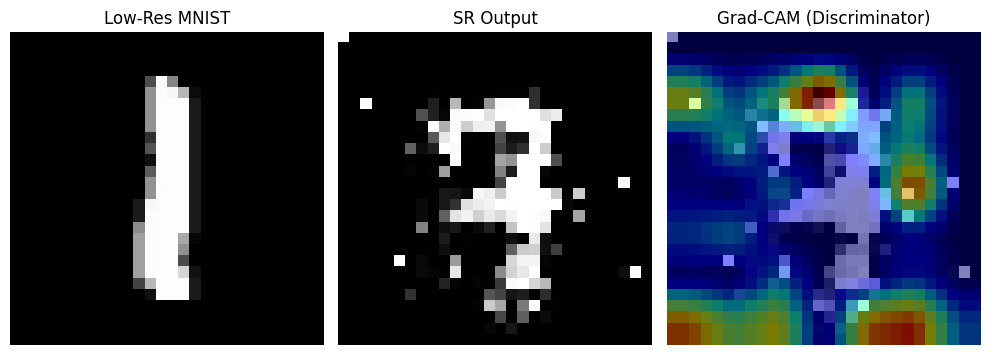

In [45]:
# === Step 6: Run Grad-CAM ===
target_layer = 'features.3'  # LeakyReLU after second Conv2d
grad_cam = GradCAM(d, d.features[3])  # use second conv layer
cam_output = grad_cam(sr_img)

# === Plotting ===
def show_img(img):
    import numpy as np
    import torch

    # Convert tensor to numpy
    if isinstance(img, torch.Tensor):
        img = img.detach().cpu().numpy()

    # Remove batch dimension if present
    if img.ndim == 2 and img.shape[0] == 1:
        img = img[0]

    # Flattened? Reshape it
    if img.ndim == 1 and img.shape[0] == 784:
        img = img.reshape(28, 28)

    return img


print(f"lr_img shape before: {lr_img.shape}")
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.title("Low-Res MNIST")
plt.imshow(show_img(lr_img), cmap='gray')
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("SR Output")
plt.imshow(show_img(sr_img), cmap='gray')
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Grad-CAM (Discriminator)")
plt.imshow(show_img(sr_img), cmap='gray')
plt.imshow(cam_output, cmap='jet', alpha=0.5)
plt.axis("off")

plt.tight_layout()
plt.show()

Once again, I encourage you not to place excessive emphasis on the results, as we are utilizing models with limited training for academic purposes. Instead, the focus should be on theoretical concepts and programming structure. I hope this material serves as a valuable guide for future projects in explainable AI. The ability of researchers to instill trust in models will be a key factor in achieving a proper and ethical integration of diverse methodologies across various industries.